# Bending of the lithosphere during subduction

**Goal:** Implement the solution to the 1D flexure equation that describes the bending of the subducting oceanic lithosphere and compare it's predictions against observations of gravity disturbances and bathymetry.

Using the 1D flexure equation, we can model the bending of the oceanic lithosphere at a subduction zone. **Our assumption is that the plate is perfectly elastic and is bending under a load placed at one of its ends.** The solution for the amount of deflection (upwards or downwards) $w$ can be expressed as:

$$
w(x) = w_b\ e^{\pi/4} \sqrt{2}
\exp\left( -\dfrac{\pi}{4}\left(\dfrac{x - x_0}{x_b - x_0}\right) \right)
\sin\left(\dfrac{\pi}{4}\left(\dfrac{x - x_0}{x_b - x_0}\right) \right)
$$

in which $w_b$ is the deflection at the peak of the forebulge, $x_b$ is the position of the peak of the forebulge, and $x_0$ is the position in which the deflection crosses the zero line. The figure below can better illustrate these parameters.

<img style="width: 500px; margin: 10px auto;" src="https://github.com/leouieda/lithosphere/raw/77a1da95fe7fcd65528bd8e30bbdcea949f5c3c7/lectures/assets/flexure-setup.svg">
<p style="text-align: left; width: 500px; max-width: 100%; margin: 30px auto;">
Figure caption: Sketch of the elastic plate flexure for an end load (placed on the left) and the geometric parameters used to derive the solution.
</p>

We can also predict the observed gravity disturbances due to the density anomalies caused by the downward deflection of the oceanic crust. The figure below illustrate a conceptual model of the density anomalies causing the observed data.

<img style="width: 500px; margin: 10px auto;" src="https://github.com/leouieda/lithosphere/raw/77a1da95fe7fcd65528bd8e30bbdcea949f5c3c7/lectures/assets/disturbance-subduction-model.svg">
<p style="text-align: left; width: 500px; max-width: 100%; margin: 30px auto;">
Figure caption: Model of the density anomalies causing the observed gravity disturbance due to subduction.
</p>

The gravitational effect of these mass anomalies can be estimated using a **Bouguer plate approximation** ($g \approx 2 \pi G \Delta\rho w$) if we know the deflection $w$ and the density of water and mantle (in practice, the density of the crust cancels out). 

**In this notebook**, we'll write functions to:

* Calculate the deflection given the geometric parameters $x_0$, $x_b$, and $w_b$ 
* Estimate the gravity disturbance caused by the deflection
* Extract a profile from our global grid datasets along a great-circle path

We'll also analyse the fit of the model to observations in different profiles to see its limitations.

## The data

**Download** (if you haven't already): [global-geophysical-data.nc](https://github.com/leouieda/lithosphere/raw/main/data/global-geophysical-data.nc) (place it in the **same folder** as this notebook)

The data grids are stored in a [netCDF](https://en.wikipedia.org/wiki/NetCDF) file, which is a very common standard for storing and distributing gridded data. It's used throughout the Earth, ocean, and climate sciences and can be read an manipulated with most software platforms. It contains global grids of gravity, topography, and heat flow. All grids were interpolated onto the same resolution of 0.2 degrees (a compromise between resolution and size of the file) so that we can easily compare and use all of the data together.

* **Gravity**: generated from the [EIGEN-6C4 spherical harmonic model](https://doi.org/10.5880/icgem.2015.1) through the [ICGEM webservice](http://icgem.gfz-potsdam.de/home). It includes two grids: the gravity disturbance calculated with the WGS84 ellipsoid and the Bouguer gravity disturbance calculated using a topography density of 2670 kg/m³. The data for both grids was generated on top of the Earth's surface (the water surface in the oceans and topography on land).
* **Topography and bathymetry**: a downsampled version of [ETOPO1](https://doi.org/10.7289/V5C8276M) and includes a version smoothed using a Gaussian filter with 1 degree width (~100 km).
* **Heat flow**: an upsampled version of the compilation by [Lucazeau (2019)](https://doi.org/10.1029/2019GC008389) (originally 0.5 degree resolution).
* **Lithosphere age (oceanic)**: a downsampled version of the grid by [Müller et al. (2008)](https://doi.org/10.1029/2007GC001743) (originally 6 arc-minutes).

## Import the required libraries

Load the required software to load the data, make maps, and perform calculations.

In [1]:
# For arrays and linear algebra
import numpy as np
# To make figures and maps
import matplotlib.pyplot as plt
# To load and manipulate grids
import xarray as xr

## Load the data grids

Once again, we'll use xarray to load the data from the netCDF file.

In [2]:
data = xr.load_dataset("global-geophysical-data.nc")
data

<xarray.Dataset>
Dimensions:              (latitude: 901, longitude: 1800)
Coordinates:
  * latitude             (latitude) float32 -90.0 -89.8 -89.6 ... 89.6 89.8 90.0
  * longitude            (longitude) float32 -180.0 -179.8 ... 179.6 179.8
    height               (latitude, longitude) float32 2.716e+03 ... 15.47
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -27.21 -27.21 ... 24.71
    gravity_bouguer      (latitude, longitude) float32 -331.2 -331.2 ... 312.6
    topography_smoothed  (latitude, longitude) float32 2.796e+03 ... -3.56e+03
    topography           (latitude, longitude) float32 2.716e+03 ... -4.213e+03
    heat_flow            (latitude, longitude) float32 75.2 75.2 ... 84.7 84.7
    lithosphere_age      (latitude, longitude) float32 nan nan ... 55.46 55.46

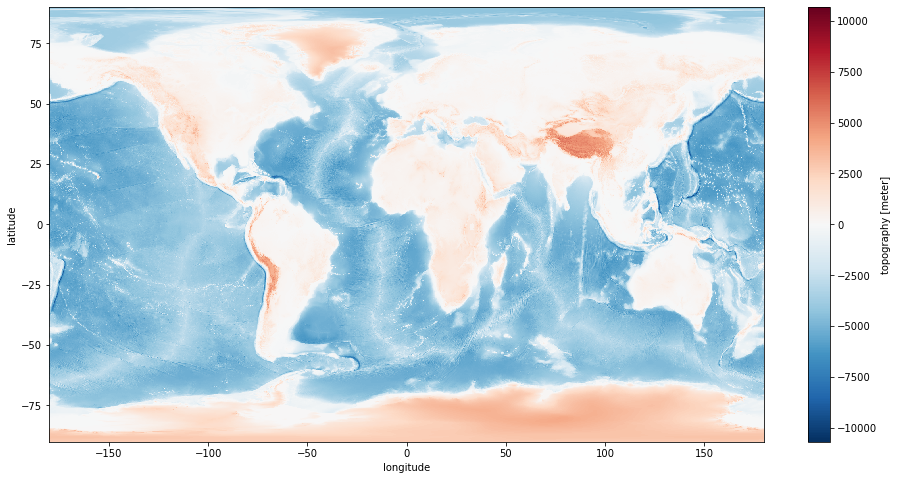

In [3]:
data.topography.plot(figsize=(16, 8))

## Extracting a profile 

The first thing we'll do is extract a profile from our grid. The profile will follow a [great circle](https://en.wikipedia.org/wiki/Great_circle) path (we'll assume that the Earth is a sphere). The trick here is producing the latitude and longitude coordinates of point that are evenly spaced along the profile. This is the problem of finding [way points along a great circle](https://en.wikipedia.org/wiki/Great-circle_navigation#Finding_way-points), which is not trivial but has a well established solution.

The function below employs this solution to generate longitude and latitude coordinates for points along a great circle path between start and end points. The links provided in the code explain where the equations come from and why we return `xarray.DataArray`s instead of just the longitude and latitude numpy arrays.

In [4]:
def profile_points(start, end, npoints):
    """
    Generate the evenly spaced points between start and end.
    Both start and end should be (longitude, latitude) pairs.
    The profile points follow a great circle.
    Returns the longitude and latitude coordinates of each point
    in a format that can be used with xarray.
    """
    lon1, lat1 = np.radians(start)
    lon2, lat2 = np.radians(end)
    # These are needed to calculate the lon/lat coordinates of the profile.
    # See https://en.wikipedia.org/wiki/Great-circle_navigation#Finding_way-points
    azimuth1 = np.arctan2(
        np.cos(lat2) * np.sin(lon2 - lon1),
        np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)
    )
    azimuth_equator = np.arctan2(
        np.sin(azimuth1) * np.cos(lat1),
        np.sqrt(np.cos(azimuth1) ** 2 + np.sin(azimuth1) ** 2 * np.sin(lat1) ** 2)
    )    
    great_circle_equator = np.arctan2(np.tan(lat1), np.cos(azimuth1))
    lon_equator = lon1 - np.arctan2(
        np.sin(azimuth_equator) * np.sin(great_circle_equator),
        np.cos(great_circle_equator)
    )
    # The great-circle distance between start and end (in radians)
    # This is the haversine formula: https://en.wikipedia.org/wiki/Haversine_formula
    great_circle_distance = 2 * np.arcsin(
        np.sqrt(
            np.sin((lat2 - lat1) / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1) / 2) ** 2
        )
    )
    # Generate evenly spaced points along the great circle 
    distances = np.linspace(start=0, stop=great_circle_distance, num=npoints)
    # Make the distances relative to where the great circle cross the equator
    # This is needed for the calculations below.
    distances_equator = distances + great_circle_equator 
    # Calculate the lon/lat coordinates of each point given their arc distance
    # and the azimuth of the great circle
    latitudes = np.arctan2(
        np.cos(azimuth_equator) * np.sin(distances_equator),
        np.sqrt(np.cos(distances_equator) ** 2 + (np.sin(azimuth_equator) * np.sin(distances_equator)) ** 2)
    )
    longitudes = lon_equator + np.arctan2(
        np.sin(azimuth_equator) * np.sin(distances_equator), 
        np.cos(distances_equator)
    )
    # Convert the arc-distances into kilometers
    mean_earth_radius = 6_371
    distances *= mean_earth_radius
    # xarray stuff so we can interpolate values on these coordinates
    # see: http://xarray.pydata.org/en/stable/interpolation.html#advanced-interpolation
    longitude = xr.DataArray(np.degrees(longitudes), coords={"distance": distances}, dims="distance")    
    latitude = xr.DataArray(np.degrees(latitudes), coords={"distance": distances}, dims="distance")
    return longitude, latitude

We can now use this function to generate point for a profile cutting across the subduction zone close to Japan. 

In [5]:
longitudes, latitudes = profile_points(start=(148, 50), end=(155, 35), npoints=300)

Plot the topography grid and the profile points on a map so we can see where it's located.

In [6]:
# Slice the grid to make it easier to visualize
japan = data.sel(longitude=slice(130, 160), latitude=slice(25, 55))

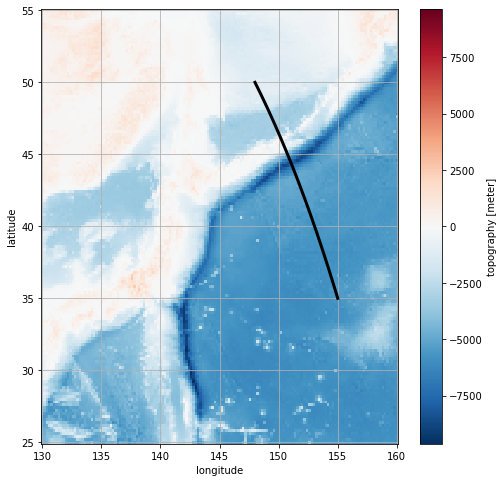

In [7]:
japan.topography.plot(figsize=(8, 8))
plt.plot(longitudes, latitudes, "-k", linewidth=3)
plt.grid()

The profile goes from the shallow [Sea of Okhotsk](https://en.wikipedia.org/wiki/Sea_of_Okhotsk) between Russia and Japan, across the suduction zone, and into the Pacific. Notice that the sudction zone is fairly straight here and the profile is perpendicular to it. **These are good features since our model assumes that there are no 2D variations in the subduction geometry.**

Once we know the longitude and latitude coordinates of the points along the profile, we can interpolate the grid values at these locations.

In [8]:
profile = data.interp(longitude=longitudes, latitude=latitudes)
profile

<xarray.Dataset>
Dimensions:              (distance: 300)
Coordinates:
    height               (distance) float64 19.96 19.99 20.03 ... 5.901 5.905
    longitude            (distance) float64 148.0 148.0 148.1 ... 155.0 155.0
    latitude             (distance) float64 50.0 49.95 49.9 ... 35.1 35.05 35.0
  * distance             (distance) float64 0.0 5.893 ... 1.756e+03 1.762e+03
Data variables:
    gravity_disturbance  (distance) float64 32.19 28.07 25.47 ... -11.51 -11.59
    gravity_bouguer      (distance) float64 100.2 97.17 95.03 ... 374.8 375.6
    topography_smoothed  (distance) float64 -1.139e+03 -1.147e+03 ... -5.633e+03
    topography           (distance) float64 -995.0 -1.011e+03 ... -5.666e+03
    heat_flow            (distance) float64 48.2 50.01 51.81 ... 51.87 52.1
    lithosphere_age      (distance) float64 nan nan nan ... 139.5 139.6 139.8

The `profile` includes all of our grid data interpolated onto the profile. It also includes the distance from the starting point along the profile, which makes it easier to make our plots and calculations.

Let's plot the topography along the profile to see what we have.

(0.0, 1761.9484155945186)

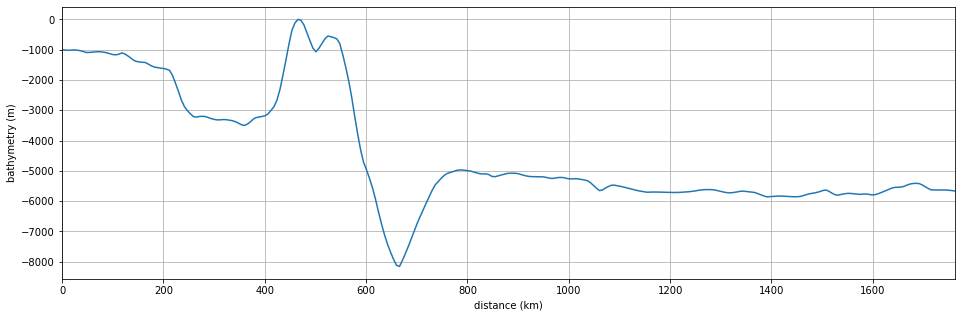

In [9]:
plt.figure(figsize=(16, 5))
plt.plot(profile.distance, profile.topography)
plt.grid()
plt.xlabel("distance (km)")
plt.ylabel("bathymetry (m)")
plt.xlim(profile.distance.min(), profile.distance.max())

Our model only includes the subducting plate so we have to crop our profile at the trench. To do so, let's find the distance coordinate for the trench, assuming that it is the deepest point in our profile.

In [10]:
distance_trench = profile.distance[profile.topography.argmin()].values
print(distance_trench)

665.8868594052863


We can now select only points in our profile that are at greater distances than the trench.

In [11]:
profile_subducting = profile.isel(distance=profile.distance >= distance_trench)

(665.8868594052863, 1761.9484155945186)

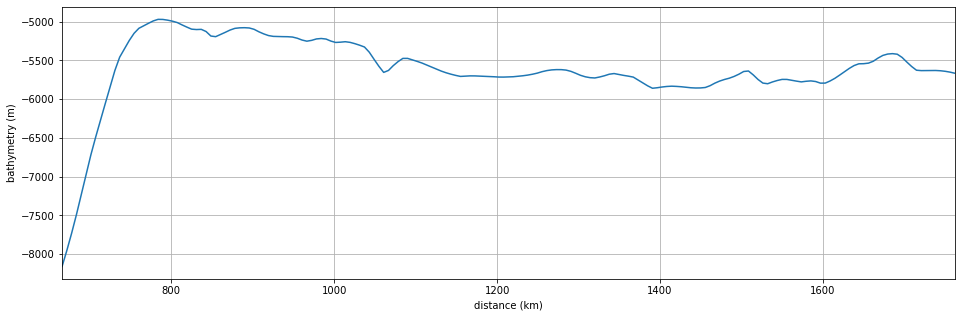

In [12]:
plt.figure(figsize=(16, 5))
plt.plot(profile_subducting.distance, profile_subducting.topography)
plt.grid()
plt.xlabel("distance (km)")
plt.ylabel("bathymetry (m)")
plt.xlim(profile_subducting.distance.min(), profile_subducting.distance.max())

This figure now looks like our sketch at the start of the notebook. You can clearly spot:

1. The place where the deflection is zero and the plate tends to a particular depth (on the right)
2. The forebulge to the right of the trench

Now we need to implement our flexure model and see if we can match these observations.

## Calculating the flexure

Let's write a function that calculates the flexure equation:

$$
w(x) = w_b\ e^{\pi/4} \sqrt{2}
\exp\left( -\dfrac{\pi}{4}\left(\dfrac{x - x_0}{x_b - x_0}\right) \right)
\sin\left(\dfrac{\pi}{4}\left(\dfrac{x - x_0}{x_b - x_0}\right) \right)
$$

It's inputs will be (all in kilometers):

* The distance along the profile ($x$)
* The distance at which the deflection cross the zero line ($x_0$)
* The distance at which the forebulge peaks ($x_b$)
* The highest amplitude of the forebulge ($w_b$)

The function will return the predicted deflection $w$ in meters.

In [13]:
def flexure_end_load(x, zero_crossing, forebulge_peak, forebulge_amplitude):
    """
    Calculate the flexure of a plate under an end load.
    Inputs should be in km. The output will be in meters.
    """
    x_scaled = (x - zero_crossing) / (forebulge_peak - zero_crossing)
    deflection = (
        forebulge_amplitude
        * np.exp(np.pi / 4) 
        * np.sqrt(2) 
        * np.exp(- np.pi / 4 * x_scaled)
        * np.sin(np.pi / 4 * x_scaled)
    )
    # Convert to meters
    return 1000 * deflection

Let's calculate the deflection based on input values derived visually from the profile.

In [14]:
deflection = flexure_end_load(
    x=profile_subducting.distance,
    zero_crossing=730,
    forebulge_peak=800,
    forebulge_amplitude=0.7,
)

(665.8868594052863, 1761.9484155945186)

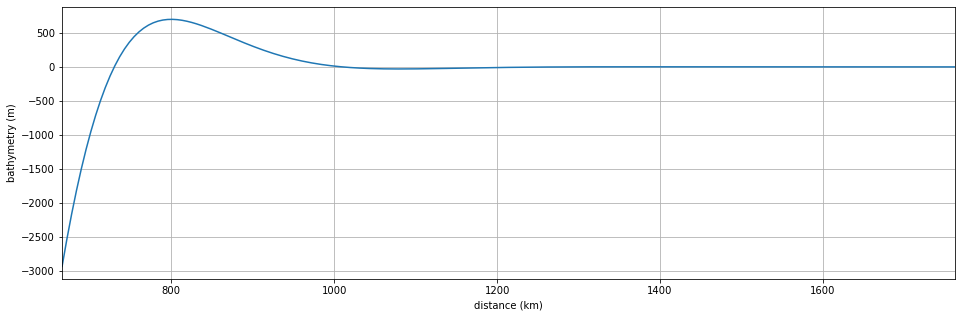

In [15]:
plt.figure(figsize=(16, 5))
plt.plot(profile_subducting.distance, deflection)
plt.grid()
plt.xlabel("distance (km)")
plt.ylabel("bathymetry (m)")
plt.xlim(profile_subducting.distance.min(), profile_subducting.distance.max())

Note that this is **not the bathymetry** but the amount of deflection suffered by the bathymetry. To actually arrive at bathymetry, we have to add the depth of the non-deflected bathymetry (the mean value at the right of the profile). 

In [16]:
predicted_bathymetry = -5700 + deflection

(665.8868594052863, 1761.9484155945186)

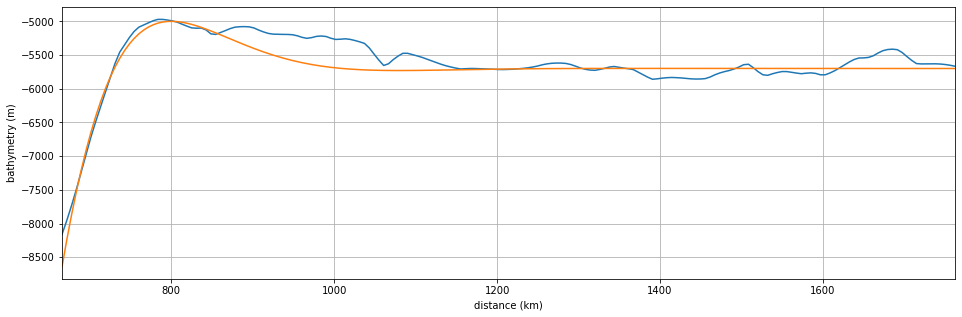

In [17]:
plt.figure(figsize=(16, 5))
plt.plot(profile_subducting.distance, profile_subducting.topography)
plt.plot(profile_subducting.distance, predicted_bathymetry)
plt.grid()
plt.xlabel("distance (km)")
plt.ylabel("bathymetry (m)")
plt.xlim(profile_subducting.distance.min(), profile_subducting.distance.max())

With the values used in the model, we can actually fit the bathymetry data pretty well. The 3 geometric parameters can also tell us about the flexural rigidity and effective elastic thickness of the lithosphere. Both are important physical parameters for modelling the behaviour of plates (see the Geodynamics book for the equations).

## Predicting gravity

With the deflection that we just calculated, we can predict the gravity disturbance caused by it using the Bouguer plate approximation $g \approx 2 \pi G \Delta\rho h$. The thickness of the Bouguer plate $h$ is the absolute value of the deflection $w$ and the density contrast will be determined by the figure below.

<img style="width: 500px; margin: 10px auto;" src="https://github.com/leouieda/lithosphere/raw/77a1da95fe7fcd65528bd8e30bbdcea949f5c3c7/lectures/assets/disturbance-subduction-model.svg">
<p style="text-align: left; width: 500px; max-width: 100%; margin: 30px auto;">
Figure caption: Model of the density anomalies causing the observed gravity disturbance due to subduction.
</p>

The predicted gravity disturbance will be the sum of the effect of the top and bottom density anomalies. If we add the two Bouguer plate values, we can arrive at:

* $\Delta\rho = \rho_m - \rho_w$ for $w > 0$
* $\Delta\rho = \rho_w - \rho_m$ for $w < 0$

So in the end, the density of the crust doesn't come into the calculations. 



Let's make a function that predicts gravity disturbances given the deflection and the densities of water and mantle. The value returned will be in mGal and all inputs in SI (meters and kg/m³).

In [18]:
def gravity_flexure(deflection, density_water, density_mantle):
    """
    Predict the gravity disturbance due the flexure of the lithosphere from subducction.
    """
    G = 6.67430e-11
    density_contrast = xr.where(
        deflection >= 0,
        density_mantle - density_water,
        density_water - density_mantle,
    )
    # 10^5 converts from m/s² to mGal
    disturbance = 1e5 * 2 * np.pi * G * density_contrast * np.abs(deflection)
    return disturbance

Now predict the gravity disturbance assuming $\rho_w = 1000\ kg/m^3$ and  $\rho_m = 3300\ kg/m^3$.

In [19]:
predicted_gravity = gravity_flexure(deflection, density_water=1000, density_mantle=3300)

(665.8868594052863, 1761.9484155945186)

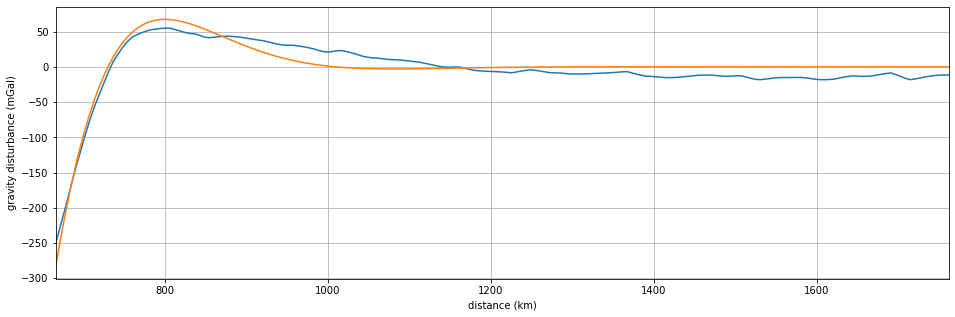

In [20]:
plt.figure(figsize=(16, 5))
plt.plot(profile_subducting.distance, profile_subducting.gravity_disturbance)
plt.plot(profile_subducting.distance, predicted_gravity)
plt.grid()
plt.xlabel("distance (km)")
plt.ylabel("gravity disturbance (mGal)")
plt.xlim(profile_subducting.distance.min(), profile_subducting.distance.max())

The fit is also very good, which indicates that our simple model with an oceanic crust of uniform density and thickness is a reasonable approximation for reality. 

---

## **Your turn!**

In groups:

1. Select one or more profiles at different locations:
    * This could be a different part of the Japan subction or a different subduction zone entirely. 
    * Aim for places that may not be as uniform as the profile we used, which has a pretty straight subduction geometry. 
    * It helps if you determine a region first, then extract a subsection of the grid and plot it to pick the coordinates for the start and end of the profile.
1. Try to fit both bathymetry and gravity using the functions we generated above. 
    * Notice that the values of $x_0$ and $x_b$ change the wavelength of the forebulge while $w_b$ only changes the amplitude.
1. Discuss:
    * **Why** the model is/isn't able to fit the data
    * What that can tell us about the subduction zone
1. Share your plots and main discussion points with the class.